In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv2D , MaxPool2D , Dense , Flatten
from tensorflow.keras import models , layers
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Preprocessing

In [9]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
dataset_path = '/content/drive/MyDrive/potato_disease/PlantVillage'


In [10]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    shuffle = True ,
    image_size = (IMAGE_SIZE , IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2162 files belonging to 3 classes.


In [11]:
 dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [12]:
class_names = dataset.class_names

In [13]:
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [14]:
#68 is actually no of baches of 32 images --> 32*68 == 2176 (it means our lass batch is not complete (have images less than 32)
len(dataset)

68

In [15]:
# dataset.take(1) is actually taking a batch out of 68 batches , not an image out of 2152 images
for image_batch , label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 1 0 1 0 2 1 1 0 1 0 1 1 0 0 1 0 1 0 1 0 0 0 0 0 0 1 1 0 2 0 0]


In [16]:
# if we want to print first image
for (image_batch , label_batch) in dataset.take(1):
    print(image_batch[0])

tf.Tensor(
[[[172. 170. 181.]
  [177. 175. 186.]
  [175. 173. 184.]
  ...
  [163. 160. 169.]
  [161. 158. 167.]
  [154. 151. 160.]]

 [[181. 179. 190.]
  [166. 164. 175.]
  [167. 165. 176.]
  ...
  [143. 140. 149.]
  [139. 136. 145.]
  [133. 130. 139.]]

 [[177. 175. 186.]
  [181. 179. 190.]
  [183. 181. 192.]
  ...
  [158. 155. 164.]
  [154. 151. 160.]
  [149. 146. 155.]]

 ...

 [[187. 182. 188.]
  [186. 181. 187.]
  [184. 179. 185.]
  ...
  [145. 138. 145.]
  [161. 154. 161.]
  [157. 150. 157.]]

 [[190. 185. 191.]
  [189. 184. 190.]
  [188. 183. 189.]
  ...
  [134. 127. 134.]
  [145. 138. 145.]
  [139. 132. 139.]]

 [[189. 184. 190.]
  [190. 185. 191.]
  [190. 185. 191.]
  ...
  [161. 154. 161.]
  [151. 144. 151.]
  [153. 146. 153.]]], shape=(256, 256, 3), dtype=float32)


#### Data Visualization

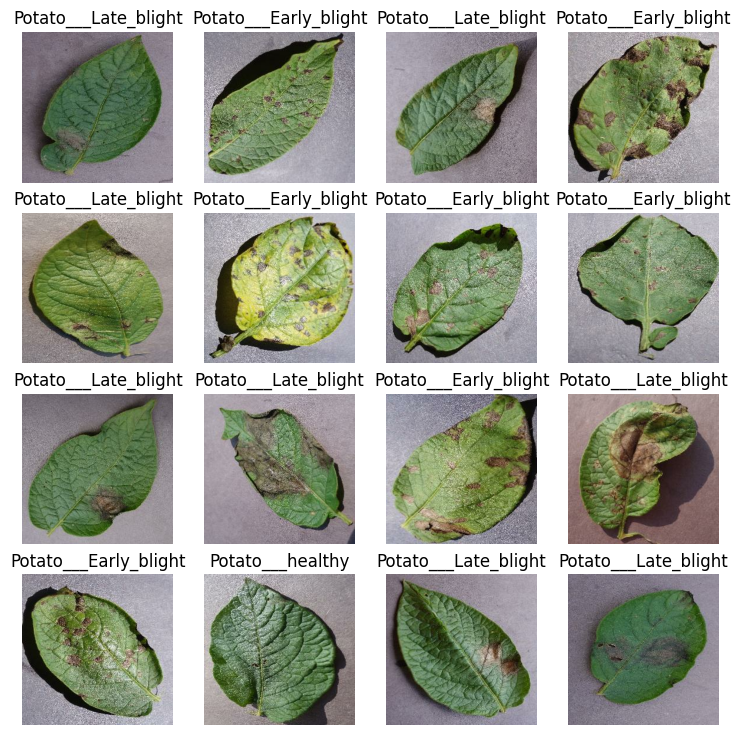

In [17]:
plt.figure(figsize = (9,9))
for i, (image,label) in enumerate(dataset.take(16)):
    ax = plt.subplot(4,4,i+1)
    plt.imshow(image[i].numpy().astype("uint8"))
    plt.title(class_names[label[i]])
    plt.axis("off")

#### Splitting dataset into train, validation and test dataset

In [18]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

In [19]:
def split(dataset, TRAIN_RATIO , VAL_RATIO , TEST_RATIO,shuffle=True , shuffle_size = 1000):

    DATASET_SIZE = len(dataset)

    if shuffle:
        dataset.shuffle(shuffle_size , seed =12)

    train_dataset = dataset.take(int(TRAIN_RATIO * DATASET_SIZE))

    val_test_dataset = dataset.skip(int(TRAIN_RATIO * DATASET_SIZE))

    val_dataset = val_test_dataset.take(int(VAL_RATIO * DATASET_SIZE))
    test_dataset = val_test_dataset.skip(int(VAL_RATIO * DATASET_SIZE))
    return train_dataset , val_dataset , test_dataset


In [20]:
train_dataset , val_dataset , test_dataset = split(dataset , TRAIN_RATIO , VAL_RATIO , TEST_RATIO)

In [21]:
len(train_dataset) , len(val_dataset) , len(test_dataset)

(54, 6, 8)

In [22]:
train_dataset =  train_dataset.shuffle(buffer_size = 8  , reshuffle_each_iteration = True).prefetch(tf.data.AUTOTUNE)
val_dataset =  val_dataset.shuffle(buffer_size = 8  , reshuffle_each_iteration = True).prefetch(tf.data.AUTOTUNE)

In [23]:
resize_and_rescale =  tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE , IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [24]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

## Model Creation

In [25]:
Input_shape = (BATCH_SIZE , IMAGE_SIZE , IMAGE_SIZE , CHANNELS)
n_classes = 3

model =  models.Sequential([
    resize_and_rescale,
    data_augmentation,

    Conv2D(filters = 32 , kernel_size = (3,3) , activation = "relu" , input_shape = Input_shape ),
    MaxPool2D(pool_size = (2,2), strides = 2),

    Conv2D(filters = 64 , kernel_size = (3,3) , activation =  "relu" ),
    MaxPool2D(pool_size = (2,2), strides = 2),

    Conv2D(filters = 64 , kernel_size = (3,3) , activation =  "relu" ),
    MaxPool2D(pool_size = (2,2), strides = 2),

    Conv2D(filters = 64 , kernel_size = (3,3) , activation =  "relu" ),
    MaxPool2D(pool_size = (2,2), strides = 2),

    Conv2D(filters = 64 , kernel_size = (3,3) , activation =  "relu" ),
    MaxPool2D(pool_size = (2,2), strides = 2),

    Conv2D(filters = 64 , kernel_size = (3,3) , activation =  "relu" ),
    MaxPool2D(pool_size = (2,2), strides = 2),

    Flatten(),

    Dense(64 , activation = "relu"),

    Dense( n_classes , activation = "softmax")
])

model.build(input_shape = Input_shape)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [26]:
model.compile(
    optimizer = "adam",
    loss = SparseCategoricalCrossentropy(),
    metrics = ["accuracy"]
)

In [27]:
history = model.fit(train_dataset , epochs = 50 ,batch_size = BATCH_SIZE, validation_data = val_dataset , verbose = 1)

Epoch 1/50
54/54 [==============================] - 300s 5s/step - loss: 0.9041 - accuracy: 0.5087 - val_loss: 0.7672 - val_accuracy: 0.6458
Epoch 2/50
54/54 [==============================] - 14s 231ms/step - loss: 0.6297 - accuracy: 0.7176 - val_loss: 0.7226 - val_accuracy: 0.7396
Epoch 3/50
54/54 [==============================] - 14s 224ms/step - loss: 0.4179 - accuracy: 0.8154 - val_loss: 0.5094 - val_accuracy: 0.7969
Epoch 4/50
54/54 [==============================] - 20s 331ms/step - loss: 0.2924 - accuracy: 0.8785 - val_loss: 0.3673 - val_accuracy: 0.8333
Epoch 5/50
54/54 [==============================] - 14s 231ms/step - loss: 0.1485 - accuracy: 0.9444 - val_loss: 0.1423 - val_accuracy: 0.9323
Epoch 6/50
54/54 [==============================] - 14s 228ms/step - loss: 0.1849 - accuracy: 0.9352 - val_loss: 0.0981 - val_accuracy: 0.9635
Epoch 7/50
54/54 [==============================] - 18s 304ms/step - loss: 0.1255 - accuracy: 0.9531 - val_loss: 0.1268 - val_accuracy: 0.9479
E

In [28]:
scores = model.evaluate(test_dataset)

8/8 [==============================] - 7s 103ms/step - loss: 0.0833 - accuracy: 0.9711


In [29]:
scores

[0.08329043537378311, 0.9710744023323059]

In [30]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

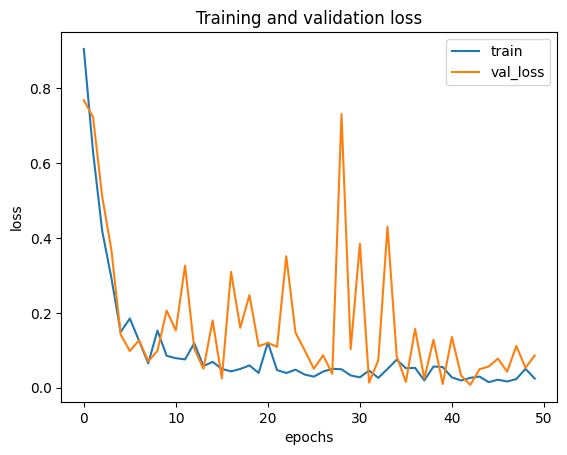

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train' , 'val_loss'])
plt.show()

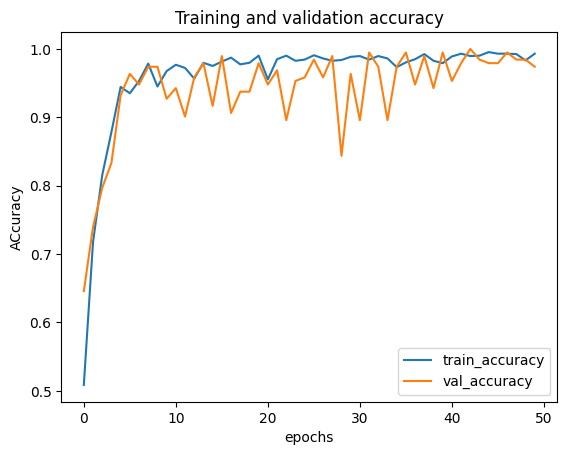

In [32]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('ACcuracy')
plt.xlabel('epochs')
plt.legend(['train_accuracy','val_accuracy'])
plt.show()

In [33]:
EPOCHS = 50
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

Text(0.5, 1.0, 'Training and Validation loss')

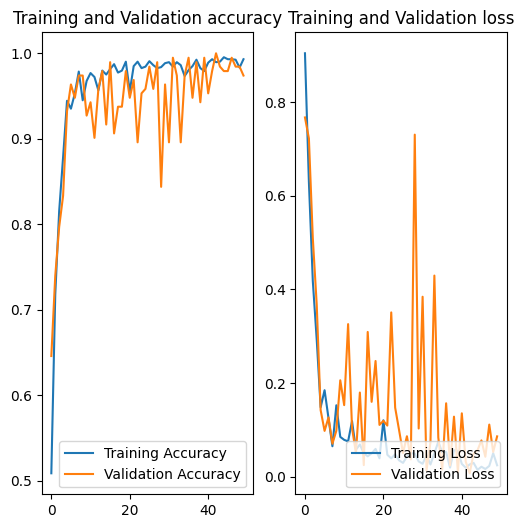

In [34]:
plt.figure(figsize = (6,6))

plt.subplot(1,2,1)
plt.plot(range(EPOCHS) , acc ,label="Training Accuracy")
plt.plot(range(EPOCHS) , val_acc , label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation accuracy")


plt.subplot(1,2,2)
plt.plot(range(EPOCHS) , loss ,label="Training Loss")
plt.plot(range(EPOCHS) , val_loss , label="Validation Loss")
plt.legend(loc="lower right")
plt.title("Training and Validation loss")

first image
first image actual label Potato___Late_blight
1/1 [==============================] - 1s 1s/step

first image predicted label Potato___Late_blight
1/1 [==============================] - 1s 995ms/step
[5.4789858e-04 9.9945176e-01 2.1863521e-07]


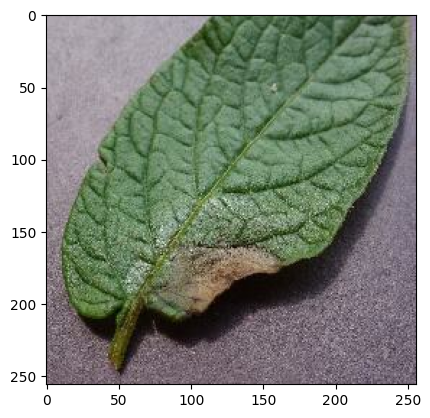

In [ ]:
for image_batch , label_batch in test_dataset.take(1):
  first_image = image_batch[0].numpy().astype("uint8")
  first_image_label = class_names[label_batch[0].numpy()]

  print("first image")
  plt.imshow(first_image)
  print("first image actual label",first_image_label)
  print("\nfirst image predicted label",class_names[np.argmax(model.predict(image_batch)[0])])
  print(model.predict(image_batch)[0])

1/1 [==============================] - 0s 28ms/step


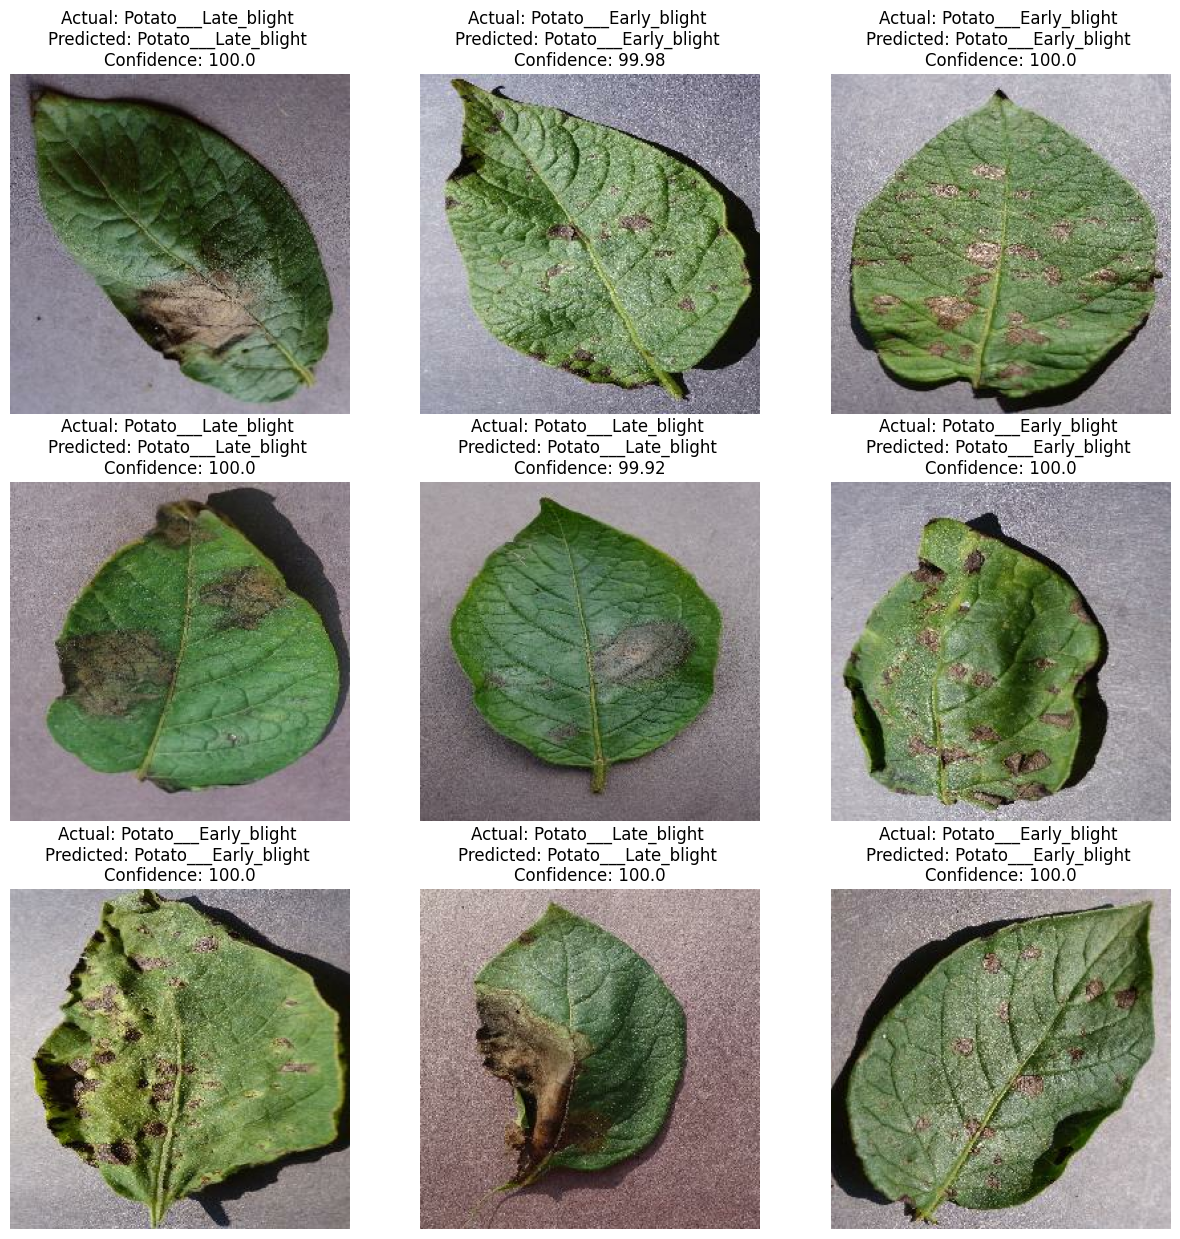

In [35]:
# plot of actual label and predicted label
plt.figure(figsize=(15,15))
for (image_batch,label_batch) in test_dataset.take(1):
  for i in range(0,9):
    ax = plt.subplot(3,3  ,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    actual_label = class_names[label_batch[i].numpy()]
    predicted_label = class_names[np.argmax(model.predict(image_batch)[i])]
    confidence = round((100*np.max(model.predict(image_batch)[i])),2)
    plt.title(f"Actual: {actual_label} \nPredicted: {predicted_label} \nConfidence: {confidence}")
    plt.axis("off")

In [ ]:
import os
from google.colab import files
model_version = max([int(i) in os.listdir("/content/drive/MyDrive/potato_disease/potato_models")+[0]])+1
model_path = f"/content/drive/MyDrive/potato_disease/potato_models/{model_version}"
save_model =  model.save(model_path)